In [2]:
import os 
import re 
import ast
import random 
from abc import ABC, abstractmethod
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

MAIN_PATH = os.path.join("/Users", "jcheigh", "Thesis")
DATA_PATH = os.path.join(MAIN_PATH, "data")
PLOT_PATH = os.path.join(MAIN_PATH, "plots")
RES_PATH  = os.path.join(MAIN_PATH, "results")

PLOT_PATHS = {
    "error plots"     : f"{PLOT_PATH}/error plots/",
    "char plots"      : f"{PLOT_PATH}/char sum plots/",   
    "fourier plots"   : f"{PLOT_PATH}/fourier plots/",   
    }

PLOT_NAME  = {
    "error plots"     : r"p = (?P<prime>\d+) error plot.jpg",
    "char plots"      : r"p = (?P<prime>\d+) char sum plot.jpg",
    "fourier plots"   : r"p = (?P<prime>\d+) fourier exp plot.jpg"
    }

PLOT_PARAMS = {
    "error plots"     : ("prime"),
    "char plots"      : ("prime"),
    "fourier plots"   : ("prime"),
    }

CSV_PATHS = {
    "raw error"       : f"{DATA_PATH}/raw_error.csv",
    "processed_error" : f"{DATA_PATH}/processed_error.csv",
    "error stats"     : f"{DATA_PATH}/error stats.csv",
    "fourier stats"   : f"{DATA_PATH}/polya fourier stats.csv",
    "char sum stats"  : f"{DATA_PATH}/char sum stats.csv"
    }

EXP_PATHS = {
    "character sum"   : f"{DATA_PATH}/char sum lists/",
    "polya fourier"   : f"{DATA_PATH}/polya fourier lists/",
    "symmetry"        : f"{DATA_PATH}/symmetry/",
    "leg fixed n"     : f"{DATA_PATH}/legendre fixed n/",
    "error lists"     : f"{DATA_PATH}/error lists/",
    'antisymmetry'    : f"{DATA_PATH}/antisymmetry/",
    'translation'     : f"{DATA_PATH}/translation"
    }  

EXP_NAME = {
    "symmetry"        : r"symmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    "polya fourier"   : r"p = (?P<prime>\d+) fourier exp list",
    "character sum"   : r"p = (?P<prime>\d+) character sum list",
    "leg fixed n"     : r"n = (?P<n>\d+) legendre symbol list",
    "error lists"     : r"p = (?P<prime>\d+) error list",
    'antisymmetry'    : r"antisymmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    'translation'     : 'translation means'
    } 

EXP_PARAMS = {
    "symmetry"        : ('prime', 'delta'),
    "polya fourier"   : ("prime"),
    "character sum"   : ("prime"),
    "leg fixed n"     : ('n'),
    "error lists"     : ("prime"),
    "antisymmetry"    : ('prime', 'delta'),
    'translation'     : ()
    }   

def process(lst):
    processed_lst = []  

    for item in lst:
        # If the item starts with a '(', consider it a tuple
        if item.startswith('('):
            try:
                # Safely evaluate the item as a tuple
                processed_tuple = ast.literal_eval(item)
                processed_lst.append(processed_tuple)
            except ValueError:
                # If there's an error, just append the original string
                processed_lst.append(item)
        else:
            try:
                # Convert the item to a float
                processed_lst.append(float(item))
            except ValueError:
                # If there's an error, just append the original string
                processed_lst.append(item)

    return processed_lst

def fetch_data(experiment):
    ### Usage: fetch_data('polya fourier')
    path   = EXP_PATHS[experiment]  # f"{DATA_PATH}/symmetry/",
    name   = EXP_NAME[experiment]   # symmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    params = EXP_PARAMS[experiment] # (prime, delta)
    
    data = {}
    for filename in os.listdir(path):
        # Match the filename with the regex pattern
        match = re.search(name, filename)
        if match:
            if isinstance(params, str):
                key = int(match.group(params))
            elif isinstance(params, tuple):
                key = tuple([int(match.group(param)) for param in params]) # (17, 3)
            else:
                raise Exception(f"Invalid Params Type: {params}")

            # Read the file and get the list of elements
            with open(os.path.join(path, filename), 'r') as file:
                elements = [line.strip() for line in file.readlines()]

            elements = process(elements)
            # Update the global dictionary
            data[key] = elements

    return data 

def read_csv(name):
    ### Usage: read_csv('processed_error')
    return pd.read_csv(CSV_PATHS[name])

def get_plot_dict(name):
    ### returns {105601 : "/Users/jcheigh/Thesis/..."}
    path   = PLOT_PATHS[name]
    params = PLOT_PARAMS[name]
    name   = PLOT_NAME[name]

    result = {}
    for filename in os.listdir(path):
        match = re.search(name, filename)
        if match:
            if isinstance(params, str):
                key = int(match.group(params))
            elif isinstance(params, tuple):
                key = tuple([int(match.group(param)) for param in params]) # (17, 3)
            else:
                raise Exception(f"Invalid Params Type: {params}")

            result[key] = os.path.join(path, filename)
    
    return result

def plot(name, params=None, N=1):
    path_map = get_plot_dict(name)
    
    if params:
        # use params
        paths = [path_map[param] for param in params]

    else:
        # or random N
        paths = random.choices(list(path_map.values()), k=N)

    for path in paths:
        try:
            img = Image.open(path)
            plt.figure(figsize = (20,10))
            plt.imshow(img)
            plt.axis('off')  # Turn off axis
            plt.show()
        except Exception:
            print(f"Plot failed")

class Saver(ABC):
    
    @property
    @abstractmethod
    def path(self):
        """Abstract property for the path where files should be saved."""
        raise NotImplementedError

    @property
    @abstractmethod 
    def type(self):
        """Abstract property for data type: one of (plot, df, list)"""
        raise NotImplementedError

    @abstractmethod
    def get_name(self, params):
        """Abstract method to generate the filename based on the parameters."""
        raise NotImplementedError
    
    def __init__(self):
        # Check if path exists, and create it if it doesn't
        if not os.path.exists(self.path):
            os.makedirs(self.path)
    
    def _get_full_path(self, name, extension):
        """Construct the full path."""
        return os.path.join(self.path, f"{name}.{extension}")

    def _check_overwrite(self, path):
        """Check if file exists and handle overwriting."""
        if os.path.exists(path):
            print(f"Overwriting {path}")
            with open(path, 'r') as f:
                original_data = f.read()
            return original_data
        return None

    def _save_data(self, params, data):
        """Save data to the specified path."""
        name = self.get_name(params)
        
        if self.type == "df":
            # Save DataFrame to .csv
            path = self._get_full_path(name, "csv")
            data.to_csv(path, index=False)
            return None

        elif self.type == "list":
            # Save list to .txt
            path = self._get_full_path(name, "txt")
            original_data = self._check_overwrite(path)
            with open(path, 'w') as f:
                for item in data:
                    f.write(f"{item}\n")
            return original_data

        elif self.type == 'plot':
            # Save plt object to .png
            path = self._get_full_path(name, "jpg")
            data.savefig(path)
            return None

        else:
            raise TypeError("Unsupported data type for saving.")

    def save(self, params, data):
        return self._save_data(params, data)

def histplot(x, bins=30, xlabel=None, title=None):
    # distribution of numerical
    plt.figure(figsize = (10,8))
    p = sns.histplot(x, bins=bins, kde=True, fill=True,
                    edgecolor="black", linewidth=3
                    )

    p.axes.lines[0].set_color("orange")
    
    if xlabel is None:
        xlabel = str(x)
        
    if title is None:
        title = f"{xlabel} Distribution"
    
    plt.ylabel("Count", fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.title(title, fontsize = 25)
    plt.show()
    return p

def countplot(x, xlabel, title = None, savefig = False, savename = None):
    # distribution of categorical
    plt.figure(figsize = (10,8))
    p = sns.countplot(x = x, order = sorted(set(x)))
    
    for container in p.containers: 
        p.bar_label(container, label_type = "center", padding = 6, size = 15, color = "black", 
                    bbox={"boxstyle": "round", "pad": 0.4,"facecolor": "#e0b583", 
                          "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})
        
    if title is None:
        title = f"Breakdown of {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_ylabel("Count",fontsize = 20)
    p.axes.set_xlabel(xlabel, fontsize = 20) 
    plt.show()  
    return p 

def violinplot(x, y, xlabel, ylabel, title = None): 
    # x is categorical, y is numerical 
    plt.figure(figsize = (10, 8))
        
    p = sns.violinplot(x = x, y = y, order = sorted(set(x)),
                       linewidth = 3, edgecolor = "black")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_xlabel(xlabel, fontsize = 20)
    p.axes.set_ylabel(ylabel, fontsize = 20)
    plt.show()
    return p

def kdeplot(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(10, 8))
    
    p = sns.kdeplot(x=x, y=y, fill=True)
    
    if title is None:
        title = f"{ylabel} by {xlabel}"
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def scatter(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(10, 8))
    sns.set(style='ticks')
    sns.set_context("poster")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p = sns.regplot(x=x, y=y)
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def char_sum_plot(prime):
    fig, ax = plt.subplots(figsize=(20,10))
    x = list(range(0, prime))
    y = char_sum_data[prime]
    ax.plot(x, y, label=f"S_p(x) for p = {prime}")

    mean, sd = np.mean(y), np.std(y)
    largest, smallest = max(y), min(y)
    
    ax.axhline(y=mean, color='b', linestyle='--', label=f"Mean(S_p(x) = {round(mean, 3)}")
    ax.axhline(y=mean + sd, color='r', linestyle='--', label=f"+1 SD = {round(mean,3)} + {round(sd, 3)}")
    ax.axhline(y=mean - sd, color='r', linestyle='--', label=f"-1 SD = {round(mean,3)} - {round(sd, 3)}")
    ax.axhline(y=largest, color='b', linestyle='--', label=f"Max(S_p(x)) = {round(largest, 3)}")
    ax.axhline(y=smallest, color='b', linestyle='--', label=f"Min(S_p(x)) = {round(smallest,3)}")
  
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("x")
    ax.set_ylabel('char sum')
    ax.set_title(f"Char Sum for p = {prime} (p = {prime % 4} mod 4)")
    return fig
    
"""Example Usage of Saver"""

class ErrorPlotSaver(Saver):
    path = PLOT_PATH
    type = 'plot'

    def get_name(self, params):
        if isinstance(params, tuple):
            prime = params[0]
        elif isinstance(params, int):
            prime = params
        else:
            raise TypeError("params should be a tuple or an integer")

        return f"p = {prime} error plot"

### USAGE:
### saver = ErrorPlotSaver()
### plot = error_plot(p)
### saver.save(plot, p)

In [3]:
df = read_csv("error stats")
df.head()

,prime,max_pos_error,max_neg_error,mean,median,std dev,x_pos_error,x_neg_error,half,least quad nonres,mae
0,117443.0,13.118478,-37.687117,-1.055982e+01,-10.441185,6.602119,39737,117147,False,NaN,NaN
1,189253.0,31.348191,-31.358018,1.585884e-16,0.000252,8.062329,124732,64520,False,NaN,NaN
2,102407.0,34.892214,-16.271328,1.158248e+01,11.386864,6.233913,28847,73341,False,NaN,NaN
3,122131.0,19.219864,-28.995691,-5.723634e+00,-5.771375,6.708070,48852,97704,False,NaN,NaN
4,118163.0,31.376575,-17.644746,5.898056e+00,5.857841,6.622325,113656,102504,False,NaN,NaN


In [4]:
df["mod"] = df["prime"].apply(lambda prime : prime % 4)
df.rename(columns={'max': 'max_pos_error', "min" : 'max_neg_error', 
                   "x_max" : "x_pos_error", "x_min" : 'x_neg_error'}, inplace=True)
df['max_error'] = df.apply(lambda row: max(row['max_pos_error'], -1 * row['max_neg_error']), axis = 1)
df['max_error_ind'] = np.where(df['max_error'] == df['max_pos_error'], 1, 0)
df["x_max_error"]   = np.where(df["max_error_ind"] == 1, df["x_pos_error"], df["x_neg_error"])
df['var'] = df['std dev'].apply(lambda x : x ** 2)
df["log error"] = df["prime"].apply(lambda p : np.floor(np.log(p) ** 2))
df["p/log(p)^2"] = df["prime"].apply(lambda p : p / (np.log(p)**2))
df['normalized mean'] = df.apply(lambda row : row["mean"] / row["prime"], axis=1)
df['normalized max error'] = df.apply(lambda row : row["max_error"] / row["prime"], axis=1)
df.head()

,prime,max_pos_error,max_neg_error,mean,median,std dev,x_pos_error,x_neg_error,half,least quad nonres,mae,mod,max_error,max_error_ind,x_max_error,var,log error,p/log(p)^2,normalized mean,normalized max error
0,117443.0,13.118478,-37.687117,-1.055982e+01,-10.441185,6.602119,39737,117147,False,NaN,NaN,3.0,37.687117,0,117147,43.587970,136.0,861.805886,-8.991446e-05,0.000321
1,189253.0,31.348191,-31.358018,1.585884e-16,0.000252,8.062329,124732,64520,False,NaN,NaN,1.0,31.358018,0,64520,65.001155,147.0,1281.829218,8.379702e-22,0.000166
2,102407.0,34.892214,-16.271328,1.158248e+01,11.386864,6.233913,28847,73341,False,NaN,NaN,3.0,34.892214,1,28847,38.861668,133.0,769.423888,1.131024e-04,0.000341
3,122131.0,19.219864,-28.995691,-5.723634e+00,-5.771375,6.708070,48852,97704,False,NaN,NaN,3.0,28.995691,0,97704,44.998202,137.0,890.227049,-4.686471e-05,0.000237
4,118163.0,31.376575,-17.644746,5.898056e+00,5.857841,6.622325,113656,102504,False,NaN,NaN,3.0,31.376575,1,113656,43.855187,136.0,866.182063,4.991457e-05,0.000266


In [4]:
df_full = df

In [5]:
print(f"Analyzed {len(df)} primes")

Analyzed 13289 primes


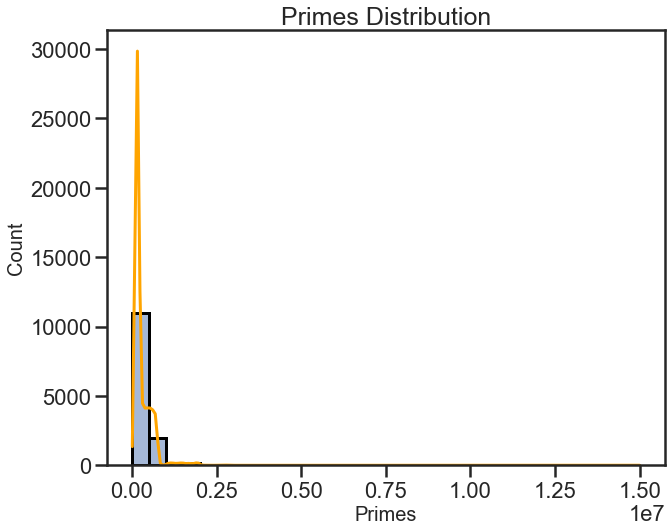

<AxesSubplot:title={'center':'Primes Distribution'}, xlabel='Primes', ylabel='Count'>

In [7]:
histplot(df["prime"], xlabel="Primes")

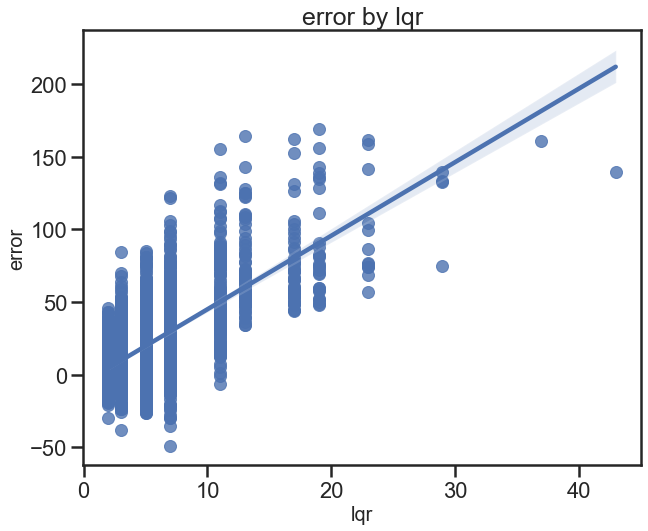

<AxesSubplot:title={'center':'error by lqr'}, xlabel='lqr', ylabel='error'>

In [8]:
lqr = df[(df["least quad nonres"] != 'N/A') & (df["mod"] == 3)]
scatter(lqr["least quad nonres"], lqr["mean"], xlabel='lqr', ylabel='error')

In [9]:
df = df[df["prime"] < 1000000] # for now just smallprimes

In [13]:
small = df[(df['prime'] < 200000)& (df['prime'] > 100000)]

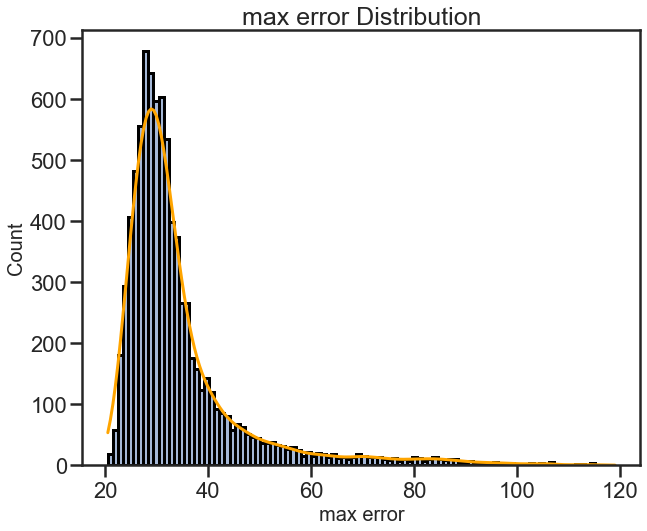

<AxesSubplot:title={'center':'max error Distribution'}, xlabel='max error', ylabel='Count'>

In [14]:
histplot(small["max_error"], bins = 100, xlabel="max error")

What distribution is this? Poisson? Beta? 



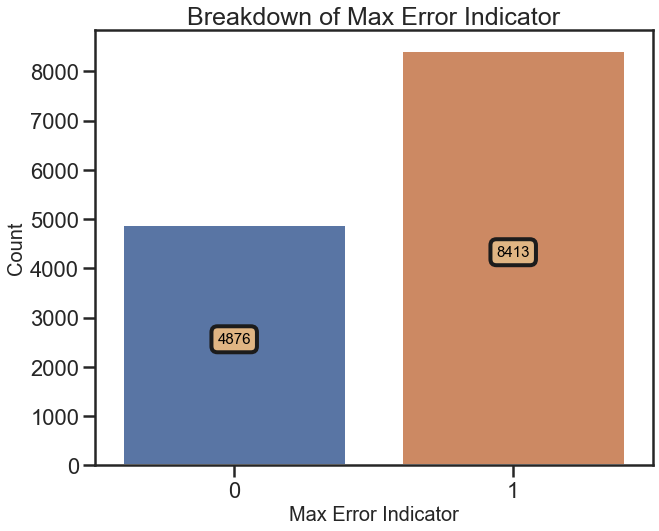

<AxesSubplot:title={'center':'Breakdown of Max Error Indicator'}, xlabel='Max Error Indicator', ylabel='Count'>

In [15]:
countplot(df["max_error_ind"], xlabel="Max Error Indicator")

In [16]:
df3 = df[df['mod'] == 3]
df1 = df[df['mod'] == 1]

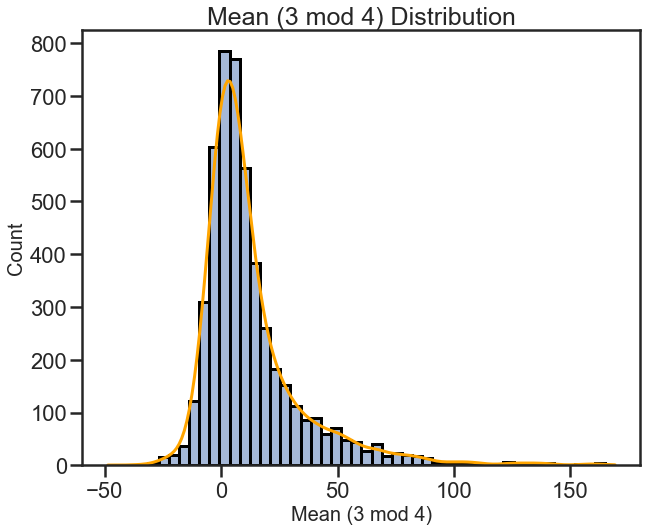

<AxesSubplot:title={'center':'Mean (3 mod 4) Distribution'}, xlabel='Mean (3 mod 4)', ylabel='Count'>

In [206]:
histplot(df3["mean"], bins=50, xlabel="Mean (3 mod 4)")

I wonder what is causing the mean of 3 mod 4 to be this way

In [207]:
fourier_lsts = fetch_data('polya fourier')
char_lsts = fetch_data("character sum")

In [208]:
primes = list(set(fourier_lsts.keys()).intersection(char_lsts.keys()))
primes = [p for p in primes if p % 4 == 3]
fourier_means = [np.mean(fourier_lsts[prime]) for prime in primes]
char_means = [np.mean(char_lsts[prime]) for prime in primes]

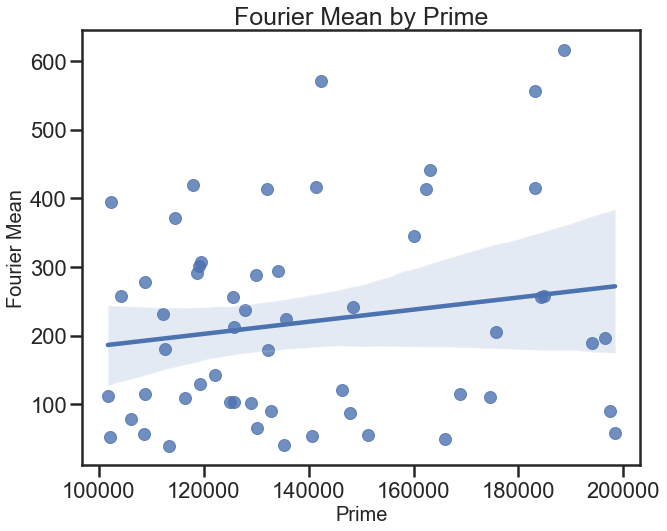

<AxesSubplot:title={'center':'Fourier Mean by Prime'}, xlabel='Prime', ylabel='Fourier Mean'>

In [209]:
scatter(primes, fourier_means, xlabel="Prime", ylabel="Fourier Mean")

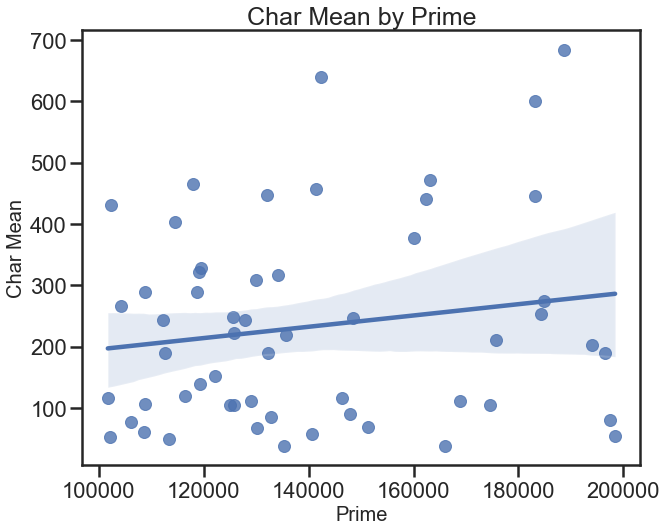

<AxesSubplot:title={'center':'Char Mean by Prime'}, xlabel='Prime', ylabel='Char Mean'>

In [210]:
scatter(primes, char_means, xlabel="Prime", ylabel="Char Mean")

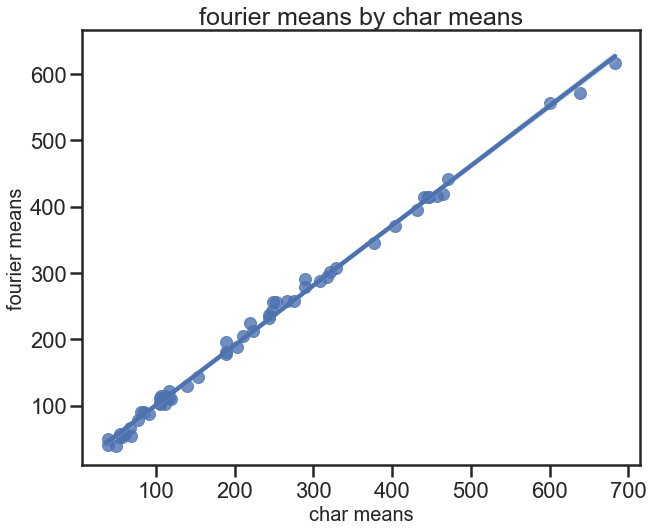

<AxesSubplot:title={'center':'fourier means by char means'}, xlabel='char means', ylabel='fourier means'>

In [211]:
scatter(char_means, fourier_means, xlabel="char means", ylabel="fourier means")

Given that variance might be pretty predictable given the prime this distribution and the max one might converge to the same thing. The thing is that this one you could be able to model easier (easier confidence interval)

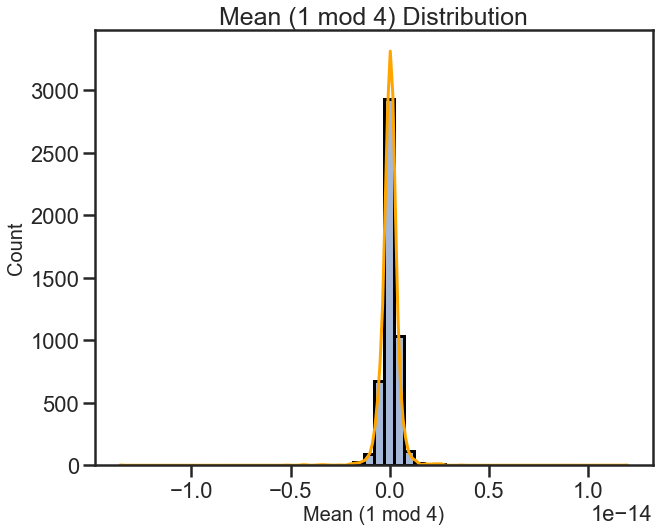

<AxesSubplot:title={'center':'Mean (1 mod 4) Distribution'}, xlabel='Mean (1 mod 4)', ylabel='Count'>

In [212]:
histplot(df1["mean"], bins=50, xlabel="Mean (1 mod 4)")

In [213]:
df1[df1['mean'] < -.6 * 10e-15]

,prime,max_pos_error,max_neg_error,mean,median,std dev,x_pos_error,x_neg_error,half,least quad nonres,mod,max_error,max_error_ind,x_max_error,var,log error,p/log(p)^2,normalized mean,normalized max error
7114,540689.0,45.910192,-45.916407,-1.360585e-14,-0.000288,12.528836,168238,372450,False,3.0,1.0,45.916407,0,372450,156.971739,174.0,3102.846007,-2.516391e-20,0.000085


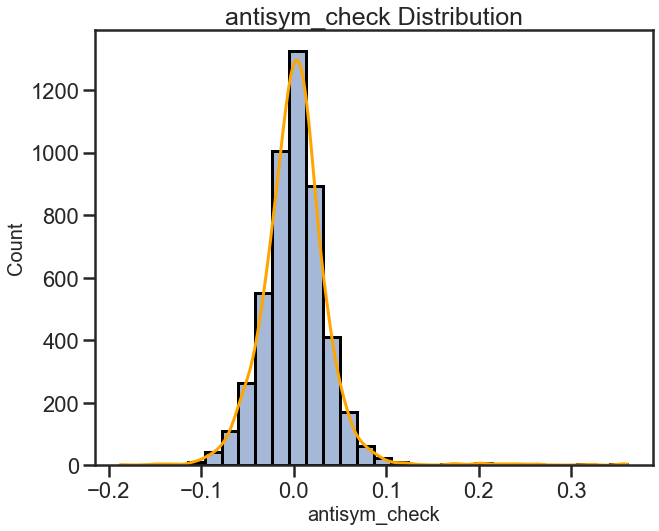

<AxesSubplot:title={'center':'antisym_check Distribution'}, xlabel='antisym_check', ylabel='Count'>

In [214]:
histplot(df1['max_pos_error'] + df1['max_neg_error'], xlabel='antisym_check')

# **Variance Analysis**

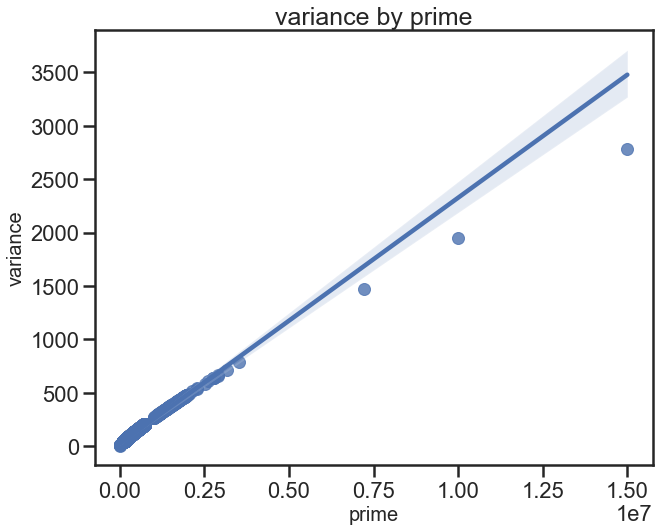

<AxesSubplot:title={'center':'variance by prime'}, xlabel='prime', ylabel='variance'>

In [17]:
scatter(df_full["prime"], df_full["var"], xlabel="prime", ylabel='variance')

Clearly, this is nonlinear. After fiddling around it seems to be 
$$
\mathrm{Var}(E_p(x)) \approx \frac{p}{\log(p)^2},
$$
or equally that 
$$
\mathrm{SD}(E_p(x)) \approx \frac{\sqrt{p}}{\log(p)}.
$$

In [18]:
np.corrcoef(df['prime'], df['var'])

array([[1.        , 0.99178315],
       [0.99178315, 1.        ]])

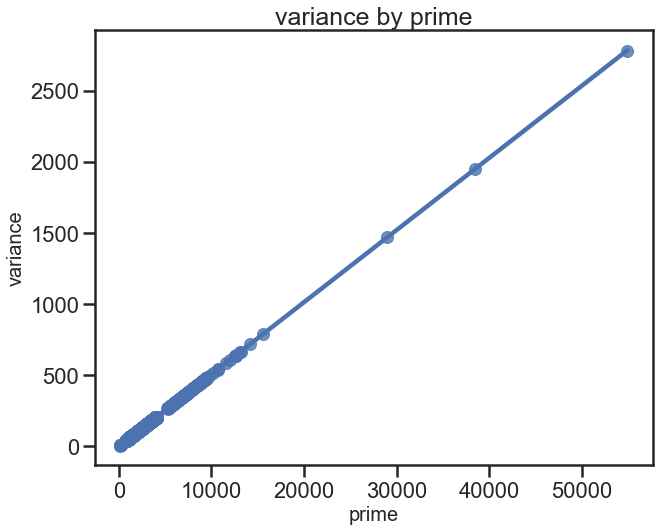

<AxesSubplot:title={'center':'variance by prime'}, xlabel='prime', ylabel='variance'>

In [19]:
scatter(df_full["p/log(p)^2"], df["var"], xlabel="prime", ylabel='variance')

For example, even these are visibly off.

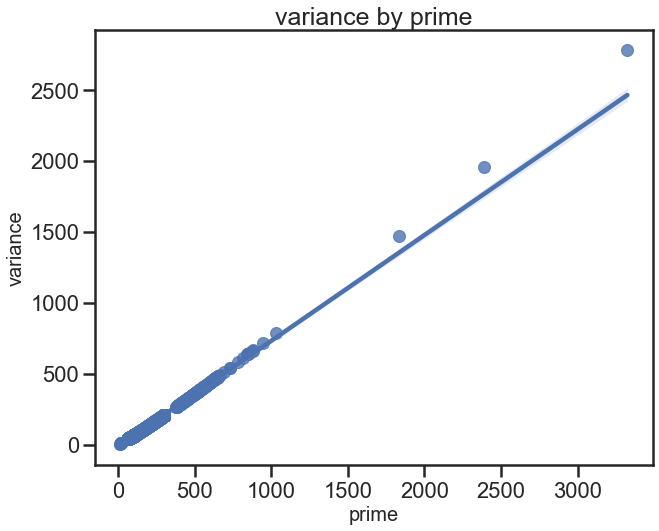

<AxesSubplot:title={'center':'variance by prime'}, xlabel='prime', ylabel='variance'>

In [20]:
scatter(df_full["p/log(p)^2"]/np.log(df["prime"]), df["var"], xlabel="prime", ylabel='variance')

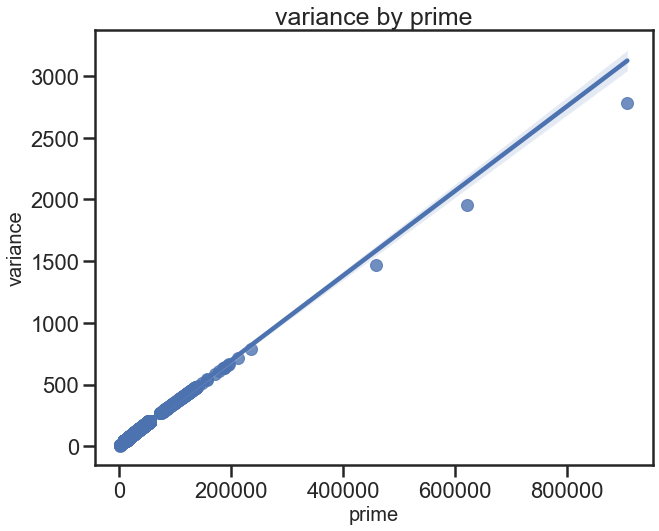

<AxesSubplot:title={'center':'variance by prime'}, xlabel='prime', ylabel='variance'>

In [21]:
scatter(df_full["p/log(p)^2"]*np.log(df["prime"]), df["var"], xlabel="prime", ylabel='variance')

However, this isn't the whole story. Let's zoom in.

In [22]:
def subset(low, high):
    return df[(df["prime"] < high ) & (df['prime'] > low)]

def plot_subset(low, high, prime=False):
    sbset = subset(low, high)
    if prime:
        scatter(sbset["prime"], sbset["var"], xlabel=f"p in [{low},{high}]", ylabel='variance')
    else:
        scatter(sbset["p/log(p)^2"], sbset["var"], xlabel=f"p/log(p)^2 for p in [{low},{high}]", ylabel='variance')

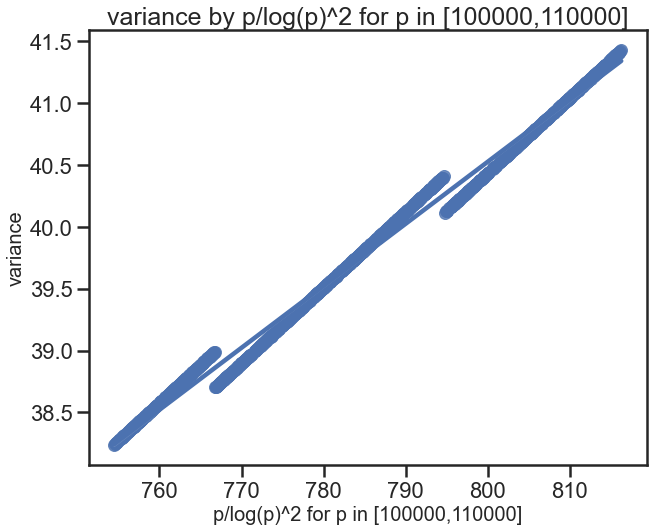

In [23]:
plot_subset(100000, 110000)

This piecewise linearity is seemingly always present:

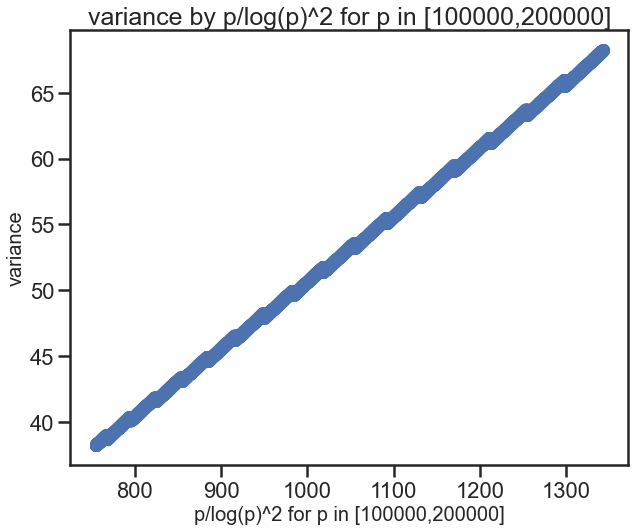

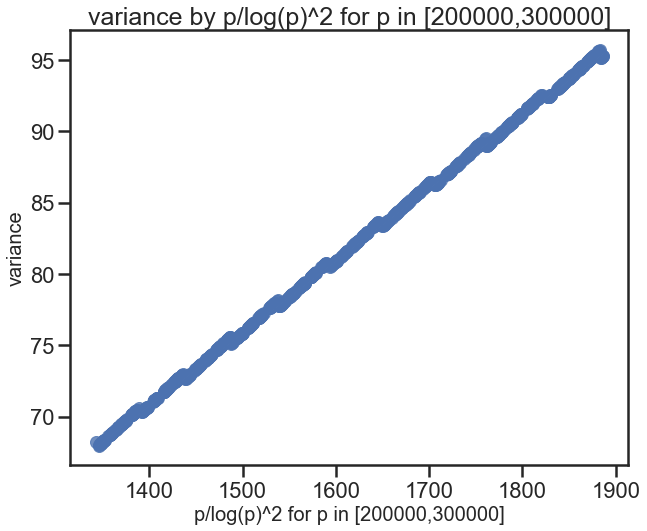

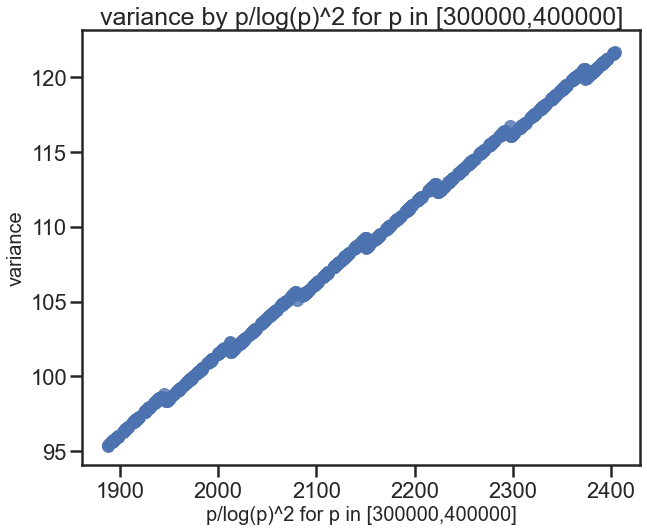

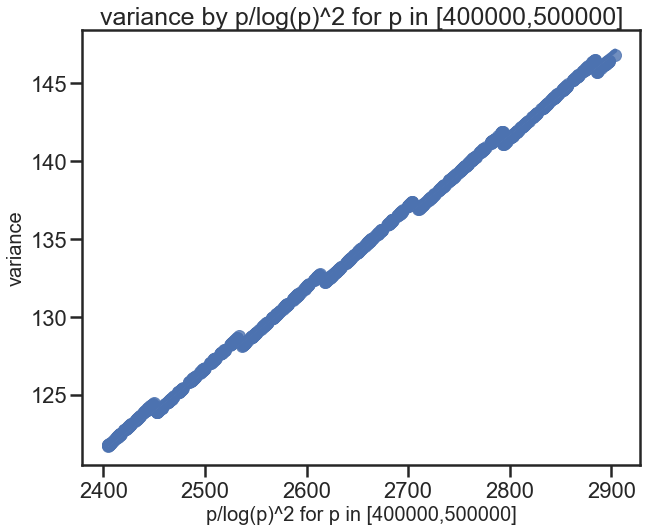

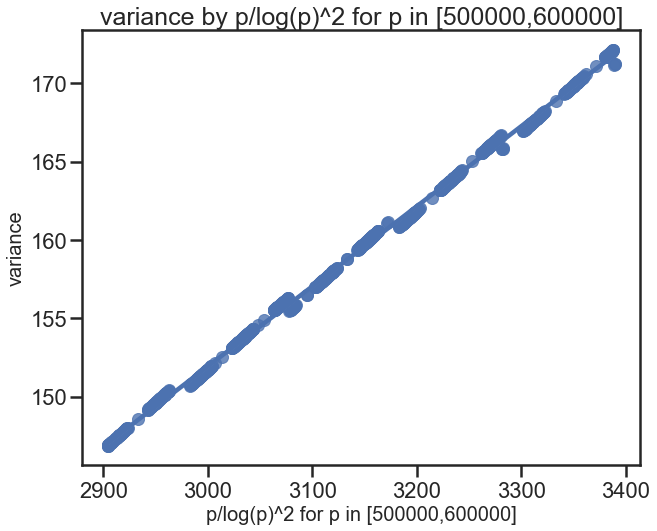

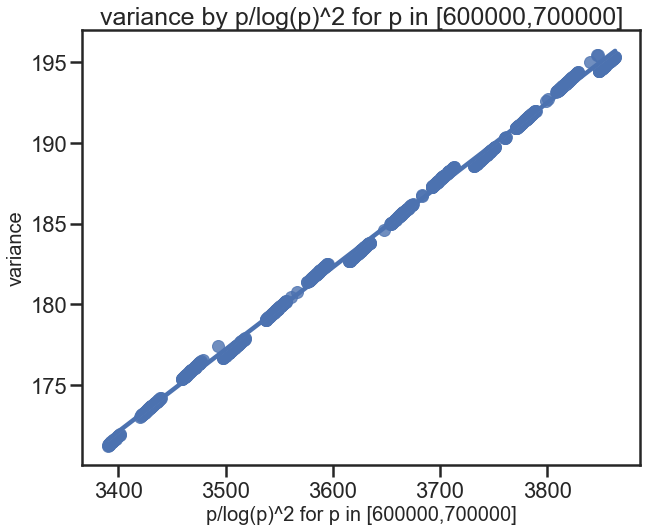

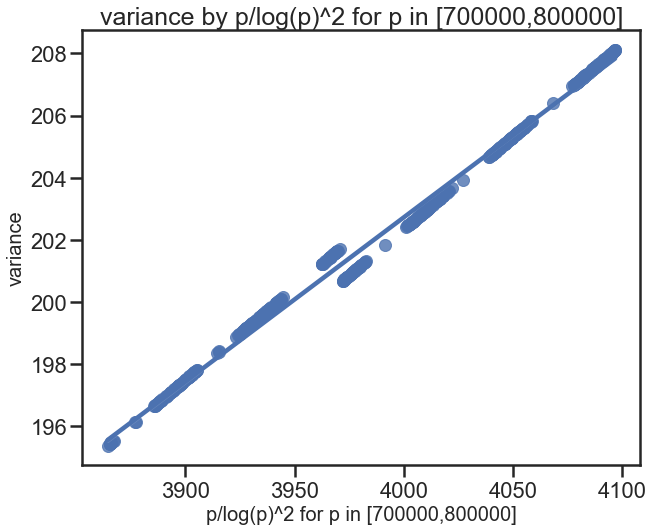

In [24]:
for k in list(range(7)):
    plot_subset(100000 * (k+1), 100000 * (k+2))

Clearly, this piecewise linearity seems to maintain, presumably forever. Further, the length of the linear portion grows with respect to p.

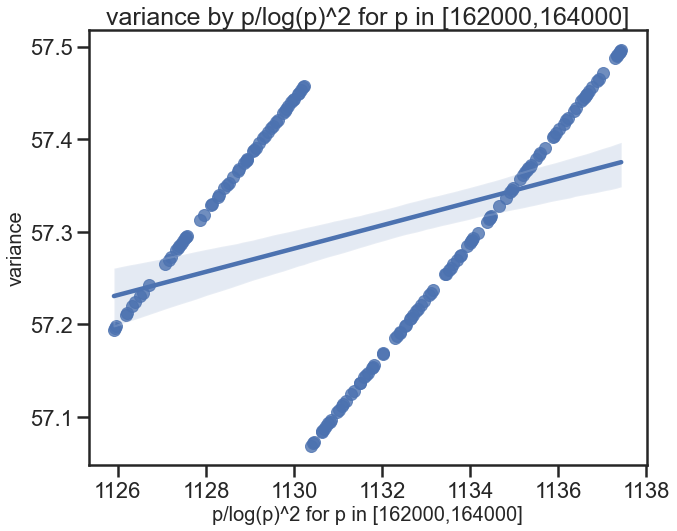

In [13]:
plot_subset(162000, 164000)

Ok, so there isn't really "error" here. So I can find the "breaks" by looking at when the variance of $p_{i+1}$ is less than the variance of $p_i$. 

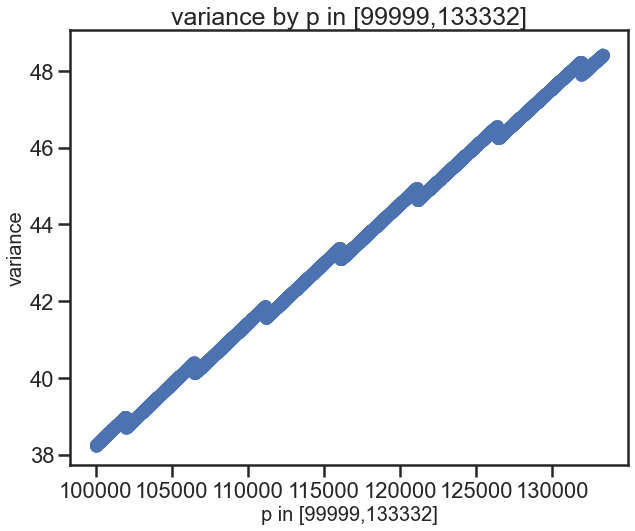

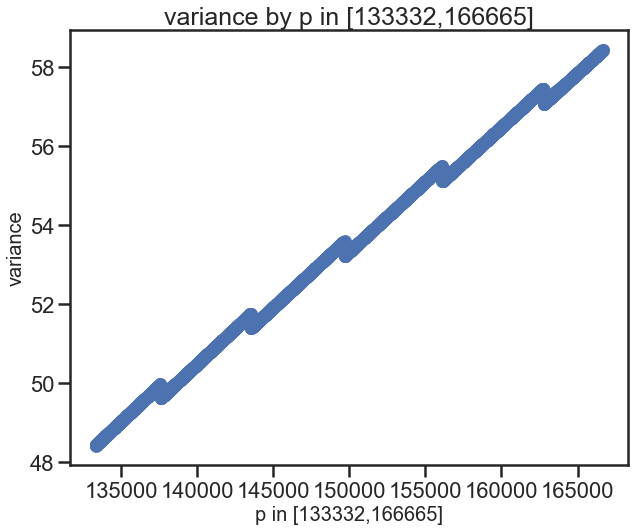

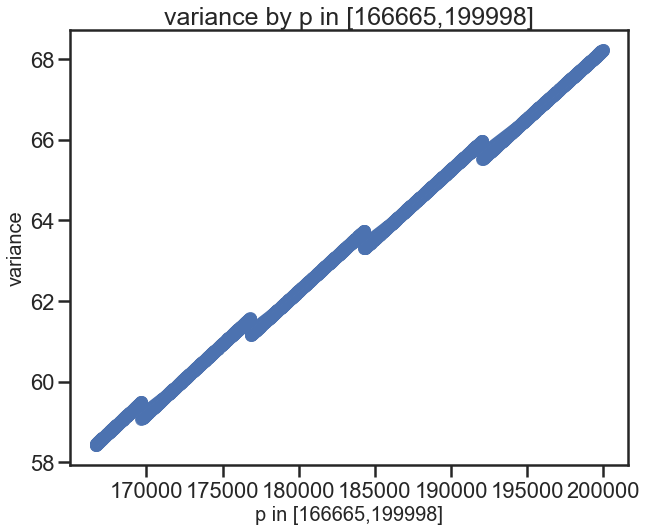

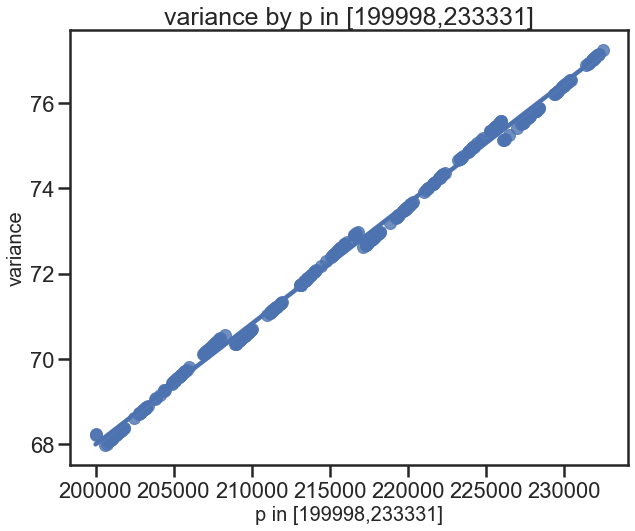

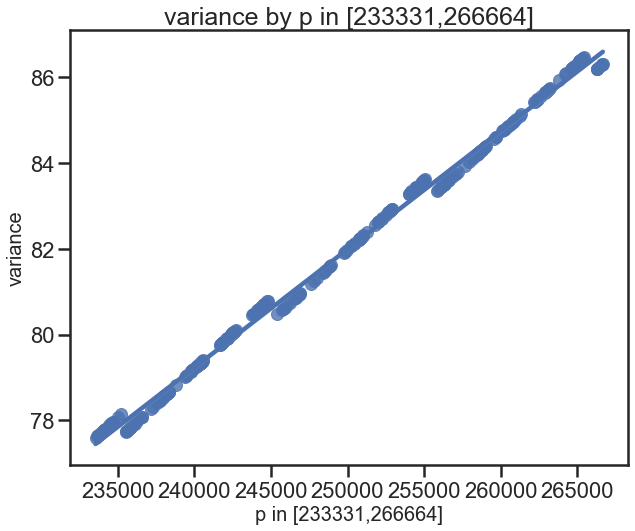

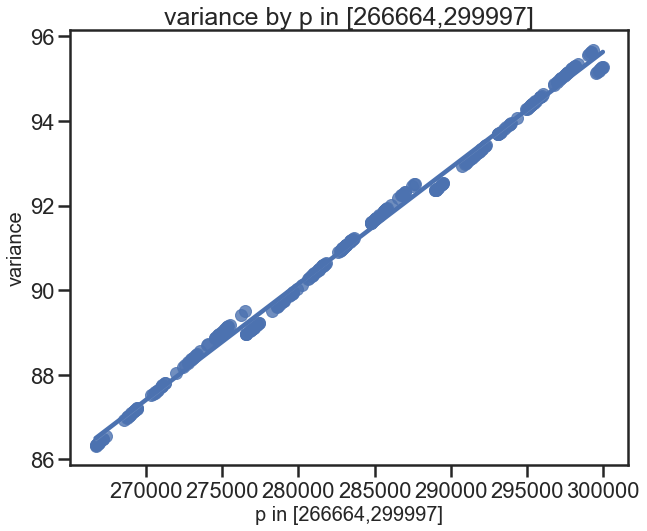

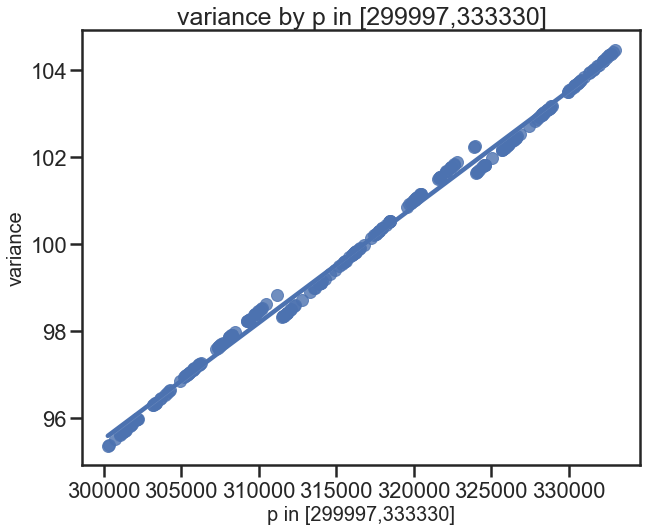

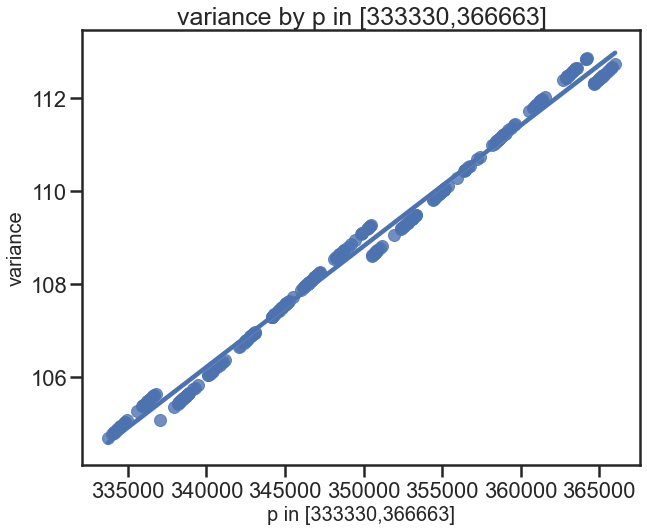

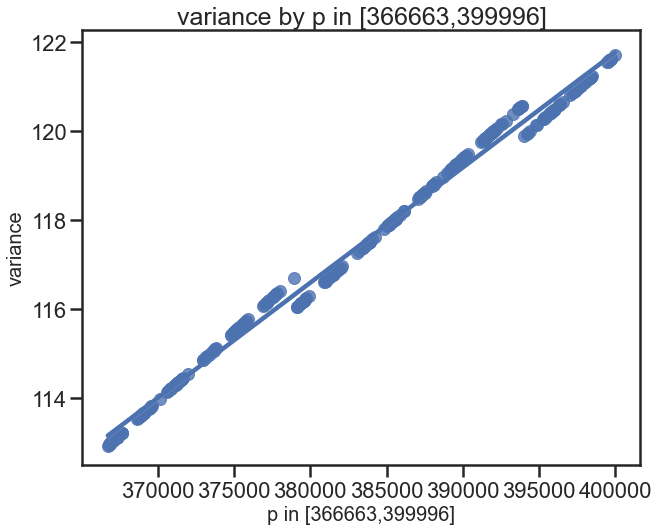

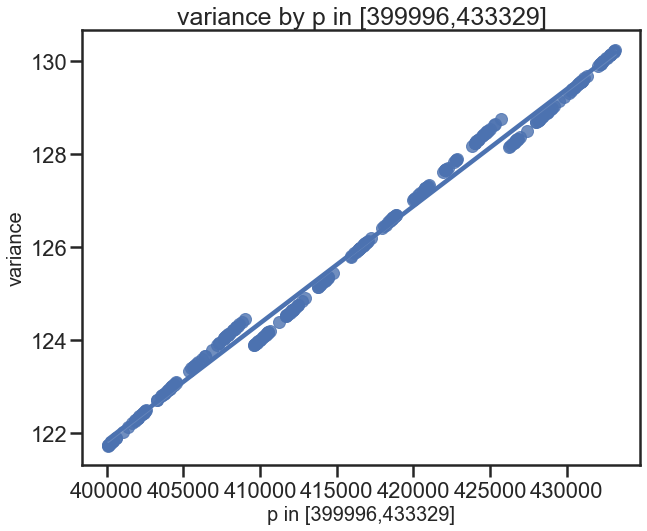

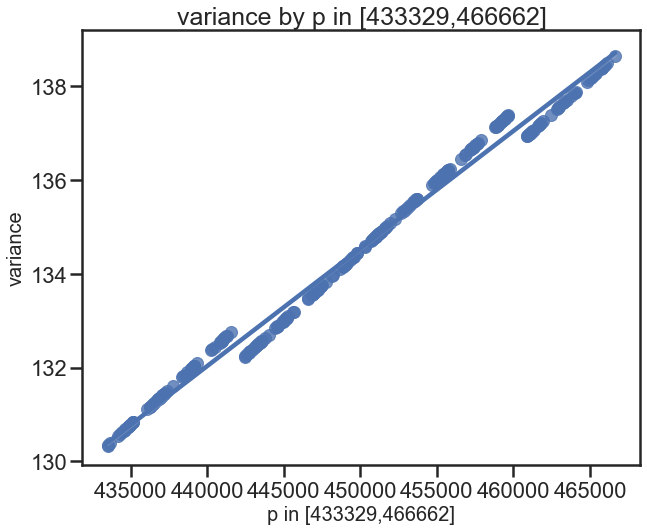

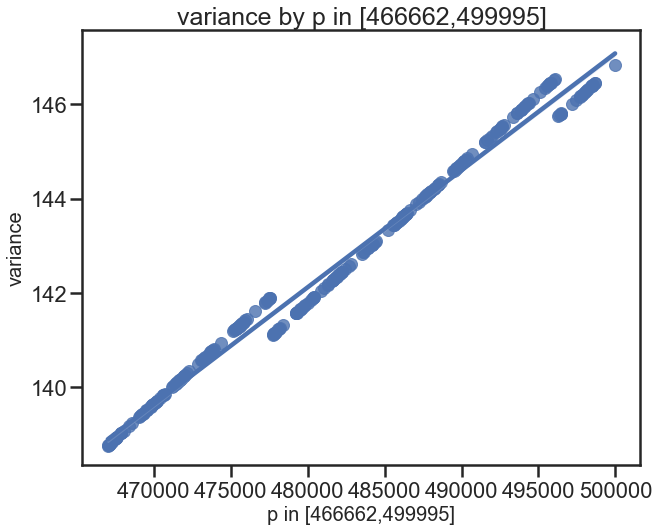

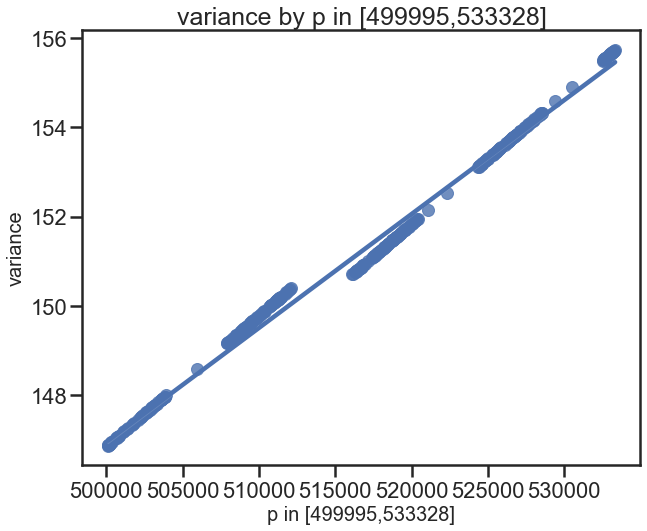

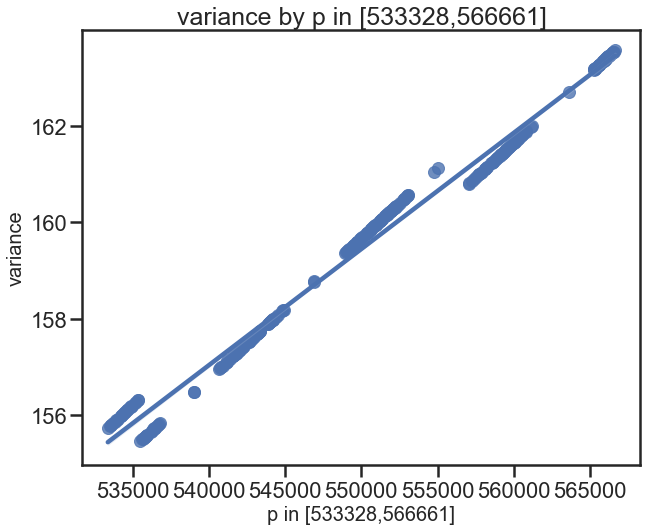

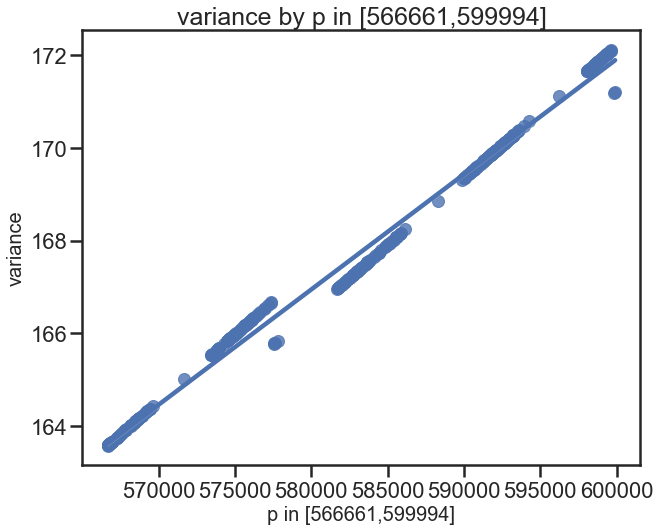

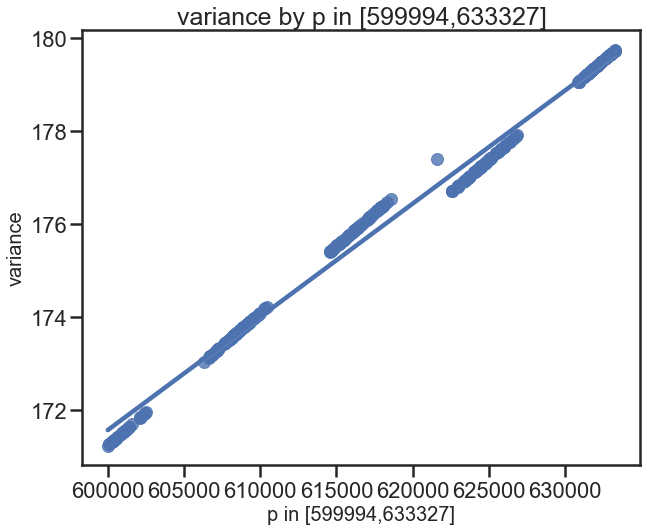

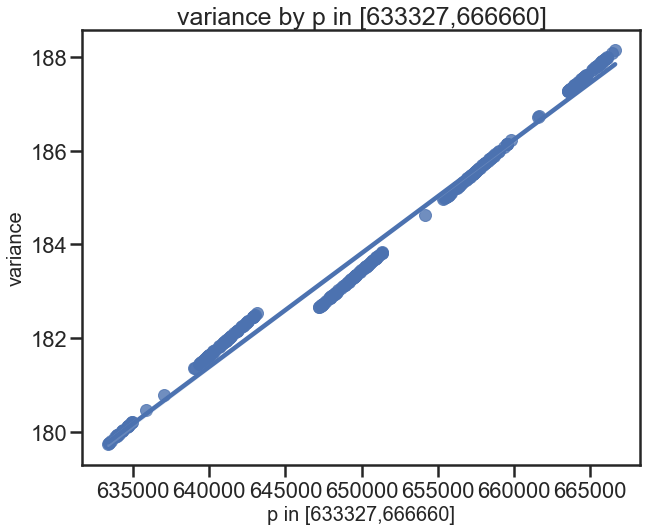

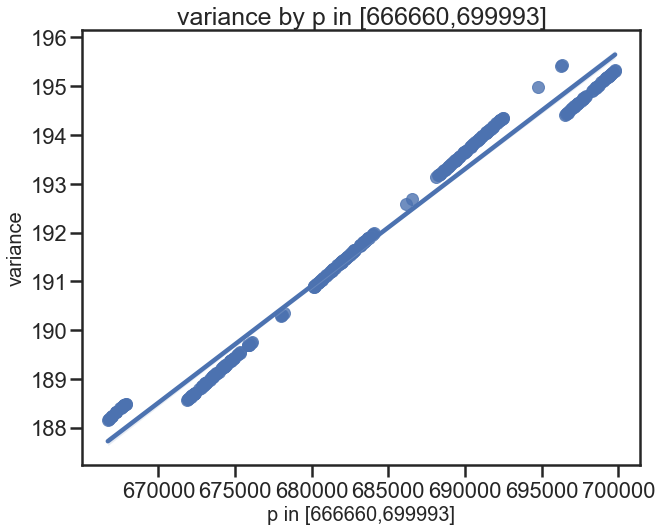

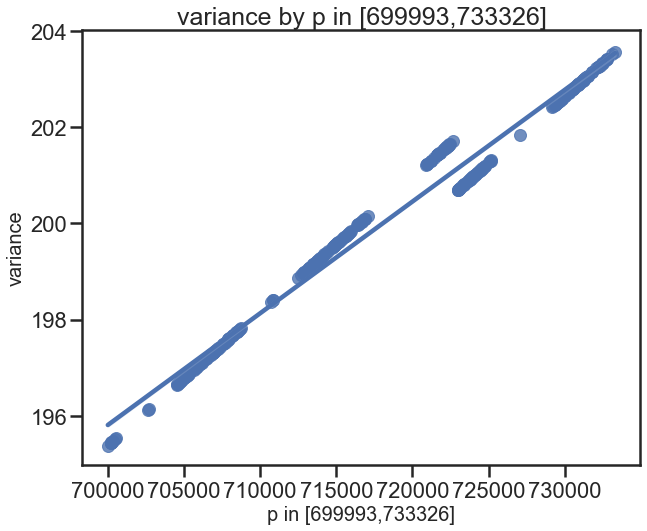

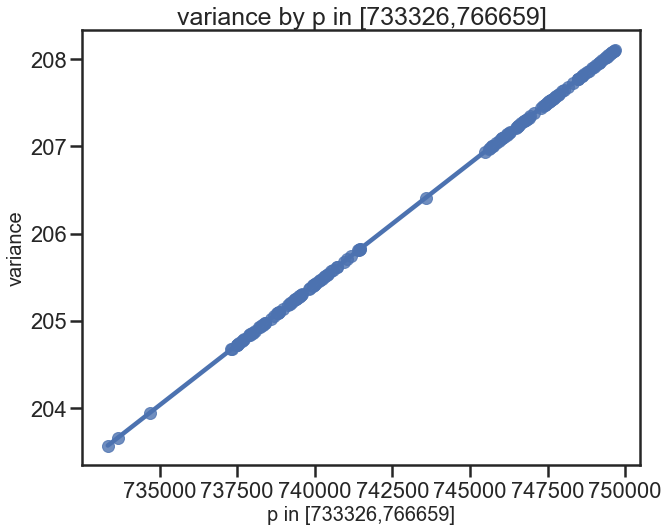

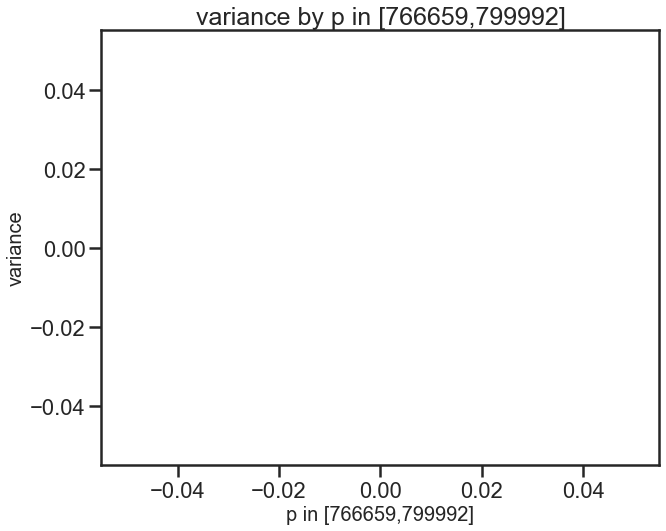

In [14]:
for k in range(3, 24):
    plot_subset(100000//3 * (k), 100000//3 * (k+1), prime=True)

In [25]:
def get_break_data(df=df_full, threshold=50000, max_prime=500000):
    df_copy = df.copy()
    df = df_copy.sort_values(by='prime')
    df = df[df['prime'] < max_prime]
    df['p_i'] = df['prime'].shift(1)
    df['var_p_i'] = df['var'].shift(1)
    filtered_df = df[df['var'] < df['var_p_i']].copy()

    # Compute the required columns
    filtered_df['p_i+1 - p_i'] = filtered_df['prime'] - filtered_df['p_i']
    filtered_df['var(p_i) - var(p_i+1)'] = filtered_df['var_p_i'] - filtered_df['var']
    filtered_df = filtered_df[filtered_df["p_i+1 - p_i"] <= threshold]
    # Select the required columns from the filtered dataframe
    result = filtered_df[['p_i', 'prime', 'p_i+1 - p_i', 'var(p_i) - var(p_i+1)', 'var_p_i', 'var']]

    result['p/log(p)^2'] = result['prime'].apply(lambda x : x / np.log(x)**2)
    result['length'] = result['p_i'] - result['prime'].shift(1)
    return result, df_full

result, df_full = get_break_data()

result

/var/folders/mk/xfkqlxln61zfl67lsk0rwfkr0000gn/T/ipykernel_63117/4098711081.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['p/log(p)^2'] = result['prime'].apply(lambda x : x / np.log(x)**2)
/var/folders/mk/xfkqlxln61zfl67lsk0rwfkr0000gn/T/ipykernel_63117/4098711081.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['length'] = result['p_i'] - result['prime'].shift(1)


,p_i,prime,p_i+1 - p_i,var(p_i) - var(p_i+1),var_p_i,var,p/log(p)^2,length
11348,101977.0,101987.0,10.0,0.288260,38.990549,38.702289,766.814490,NaN
9927,106487.0,106501.0,14.0,0.295163,40.409923,40.114759,794.773592,4500.0
11817,111149.0,111187.0,38.0,0.294754,41.865443,41.570689,823.604755,4648.0
10565,116047.0,116089.0,42.0,0.302262,43.387716,43.085453,853.565048,4860.0
12226,121139.0,121151.0,12.0,0.322550,44.959685,44.637135,884.299806,5050.0
495,126397.0,126421.0,24.0,0.327458,46.569950,46.242492,916.089093,5246.0
1617,131899.0,131909.0,10.0,0.342211,48.246214,47.904002,948.978939,5478.0
1514,137597.0,137623.0,26.0,0.346273,49.969624,49.623351,983.002524,5688.0
418,143527.0,143537.0,10.0,0.362152,51.752154,51.390003,1017.991873,5904.0
10294,149689.0,149711.0,22.0,0.368259,53.592552,53.224293,1054.287465,6152.0


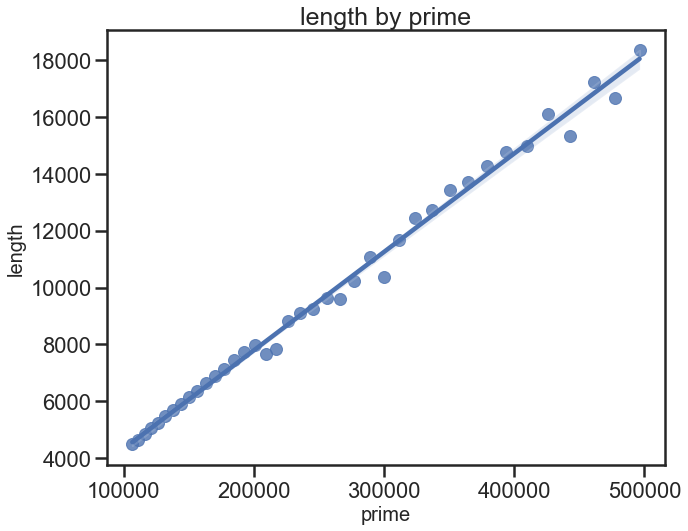

<AxesSubplot:title={'center':'length by prime'}, xlabel='prime', ylabel='length'>

In [26]:
scatter(result['prime'], result['length'], xlabel='prime', ylabel='length')

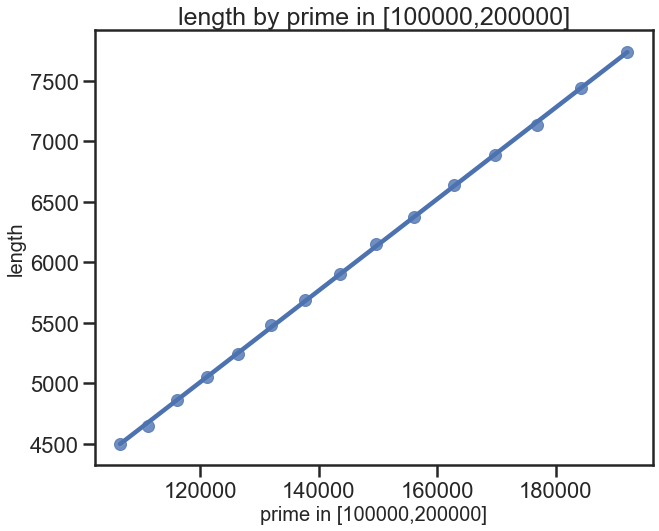

In [27]:
def subset(low, high):
    return result[(result["prime"] < high ) & (result['prime'] > low)]

def plot_length(low, high, transform = lambda x: x):
    sbset = subset(low, high)
    scatter(sbset['prime'].apply(transform), sbset["length"],  xlabel=f'prime in [{low},{high}]', ylabel='length')

plot_length(100000, 200000)

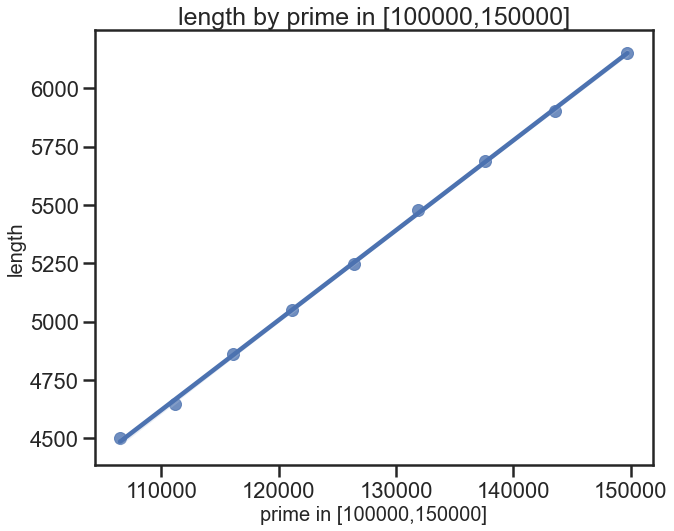

In [28]:
plot_length(100000, 150000)

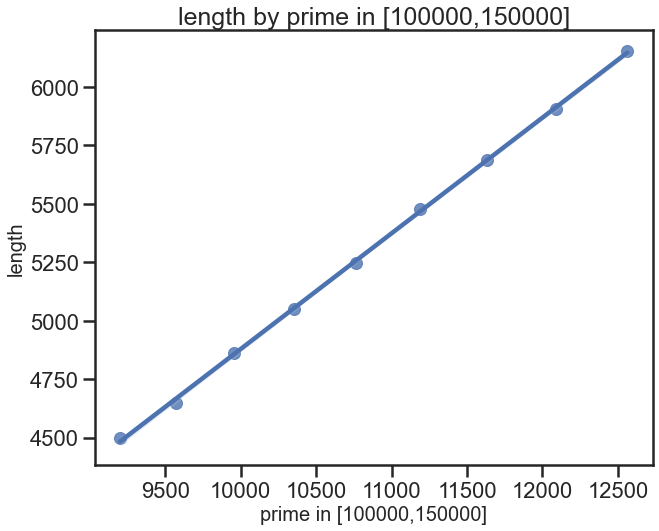

In [29]:
plot_length(100000, 150000, transform = lambda x: x / np.log(x))

In [40]:
df.sort_values(by='prime').head(25)

,prime,max_pos_error,max_neg_error,mean,median,std dev,x_pos_error,x_neg_error,half,least quad nonres,mod,max_error,max_error_ind,x_max_error,var,log error,p/log(p)^2,normalized mean,normalized max error,mae
2835,10331.0,11.466102,-6.741595,1.456926e+00,1.455250,2.474673,5165,601,False,NaN,3.0,11.466102,1,5165,6.124005,85.0,120.927603,1.410247e-04,0.001110,NaN
2839,11447.0,12.670327,-5.302908,3.969189e+00,3.960921,2.574882,10086,10146,False,NaN,3.0,12.670327,1,10086,6.630017,87.0,131.065438,3.467449e-04,0.001107,NaN
2836,15467.0,11.547075,-7.771035,1.983016e+00,1.892674,2.895223,5075,10707,False,NaN,3.0,11.547075,1,5075,8.382319,93.0,166.214838,1.282095e-04,0.000747,NaN
2841,15739.0,12.261027,-10.037500,1.540332e+00,1.593836,2.920558,14107,14148,False,NaN,3.0,12.261027,1,14107,8.529659,93.0,168.528188,9.786720e-05,0.000779,NaN
2832,16103.0,26.450100,-0.001645,1.355698e+01,13.509023,2.954122,3220,16102,False,NaN,3.0,26.450100,1,3220,8.726837,93.0,171.612784,8.418915e-04,0.001643,NaN
2838,16693.0,11.279581,-11.278518,-3.405225e-18,-0.000193,2.991781,1002,15690,False,NaN,1.0,11.279581,1,1002,8.950754,94.0,176.586145,-2.039912e-22,0.000676,NaN
2837,17107.0,9.064260,-11.626534,-1.411577e+00,-1.366832,3.012746,10163,1041,False,NaN,3.0,11.626534,0,1041,9.076640,95.0,180.057107,-8.251461e-05,0.000680,NaN
2840,17239.0,20.486282,-2.550855,8.179557e+00,8.221086,3.024343,5746,12239,False,NaN,3.0,20.486282,1,5746,9.146648,95.0,181.160619,4.744798e-04,0.001188,NaN
2833,19009.0,10.503695,-10.383154,5.681651e-17,-0.007086,3.143025,4762,14246,False,NaN,1.0,10.503695,1,4762,9.878607,97.0,195.817539,2.988927e-21,0.000553,NaN
2834,19457.0,11.699607,-11.665172,-2.811934e-16,-0.003619,3.179834,2626,16830,False,NaN,1.0,11.699607,1,2626,10.111345,97.0,199.488122,-1.445204e-20,0.000601,NaN


In [5]:
data = fetch_data('error lists')

In [6]:
get = lambda num : np.array(data[num])

In [7]:
lst1 = get(102139)
lst2 = get(102359)
p1 = 102139
p2 = 102359

In [8]:
lst1

array([ 0.00000000e+00,  9.99840817e-01, -6.36723255e-04, ...,
       -1.43259741e-03,  9.99363277e-01, -1.59182808e-04])

In [9]:
np.var(lst1)

38.759968768270646

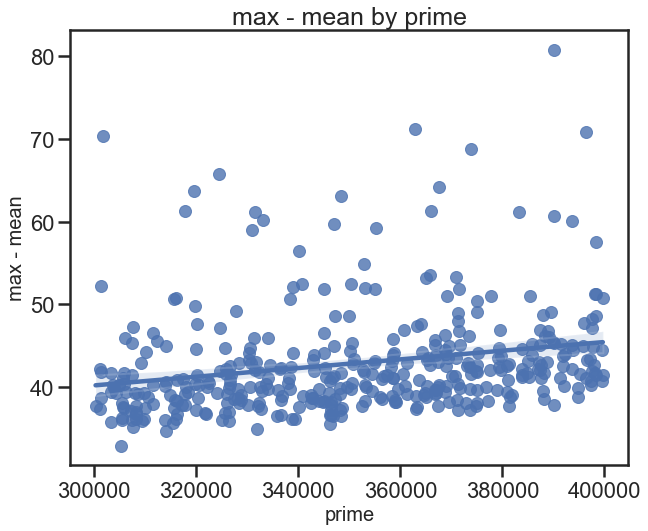

<AxesSubplot:title={'center':'max - mean by prime'}, xlabel='prime', ylabel='max - mean'>

In [29]:
small = df[(df['prime'] <= 400000) & (df['prime'] > 300000)]
df1 = small[small['mod'] == 1]
df3 = small[small['mod'] == 3]
scatter(df1['prime'], abs(df1['max_error'] - df1['mean']), xlabel='prime', ylabel='max - mean')

In [10]:
np.var(lst2)

38.84345306624835

In [11]:
def mae(lst):
    return np.sum(abs(lst - np.mean(lst))) / len(lst)

In [12]:
mae(lst1)

4.962382615190094

In [13]:
mae(lst2)

5.054207847298309

Need more data but similar, i.e. maybe something like the piecewise portions are linear w.r.t $p$ or $p/\log(p)^{\alpha}$

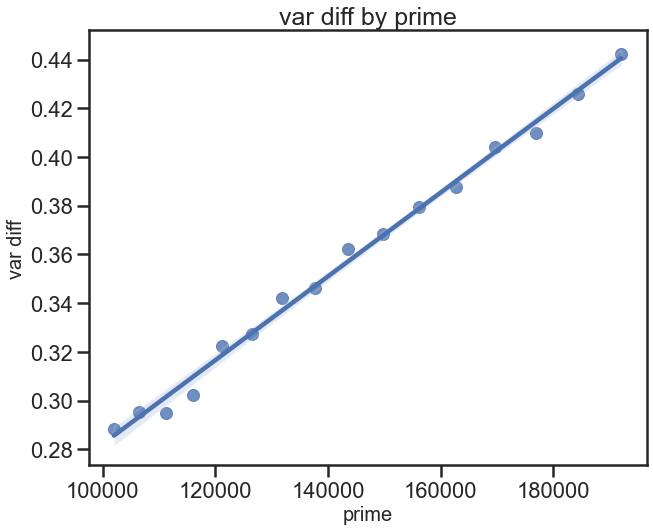

<AxesSubplot:title={'center':'var diff by prime'}, xlabel='prime', ylabel='var diff'>

In [30]:
sbset = subset(100000, 200000)
scatter(x = sbset['prime'], y=sbset['var(p_i) - var(p_i+1)'], xlabel='prime', ylabel = "var diff")

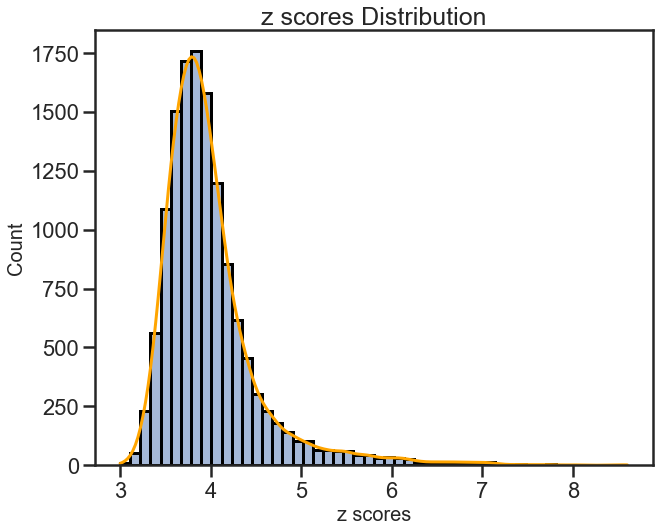

<AxesSubplot:title={'center':'z scores Distribution'}, xlabel='z scores', ylabel='Count'>

In [31]:
z_scores = abs((df['max_error'] * df['max_error_ind'].apply(lambda x : 1 if x == 1 else -1) - df['mean'])/df['std dev'])
histplot(z_scores, bins=50, xlabel='z scores')

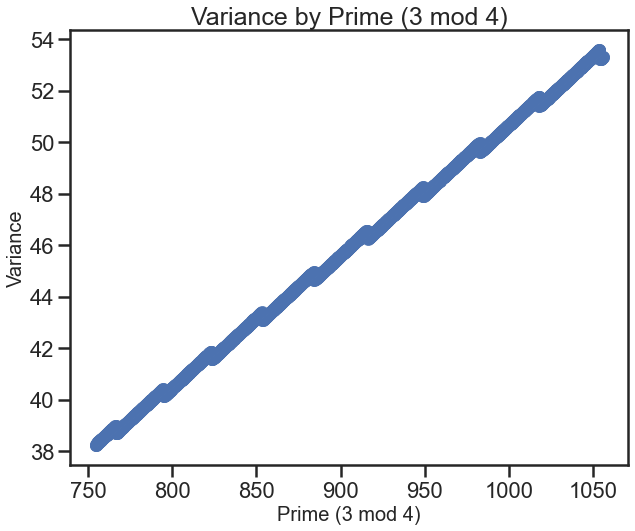

<AxesSubplot:title={'center':'Variance by Prime (3 mod 4)'}, xlabel='Prime (3 mod 4)', ylabel='Variance'>

In [34]:
df3_subset = df3[(df3["prime"] > 100000) & (df3['prime'] < 150000)]
scatter(df3_subset["p/log(p)^2"], df3_subset["var"], xlabel = "Prime (3 mod 4)", ylabel="Variance")

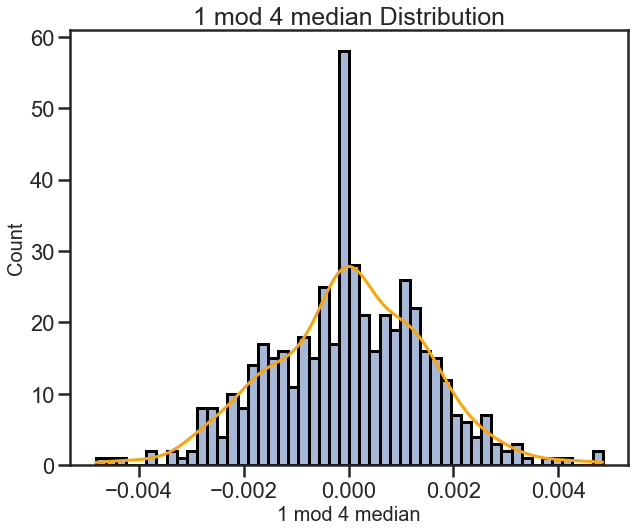

<AxesSubplot:title={'center':'1 mod 4 median Distribution'}, xlabel='1 mod 4 median', ylabel='Count'>

In [ ]:
histplot(df1["median"], bins=50, xlabel='1 mod 4 median')

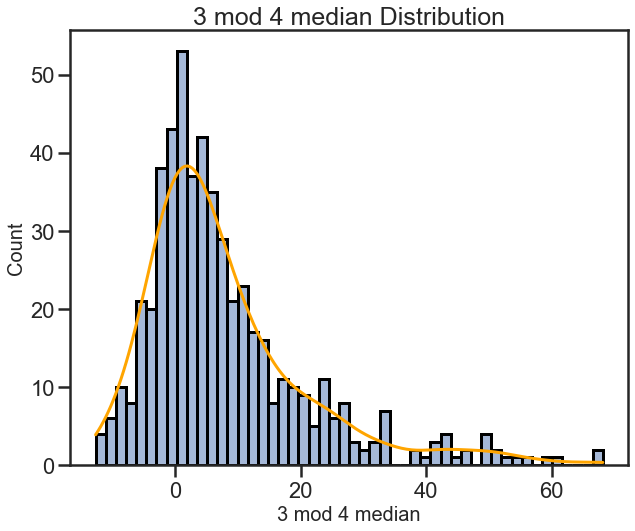

<AxesSubplot:title={'center':'3 mod 4 median Distribution'}, xlabel='3 mod 4 median', ylabel='Count'>

In [ ]:
histplot(df3["median"], bins=50, xlabel='3 mod 4 median')

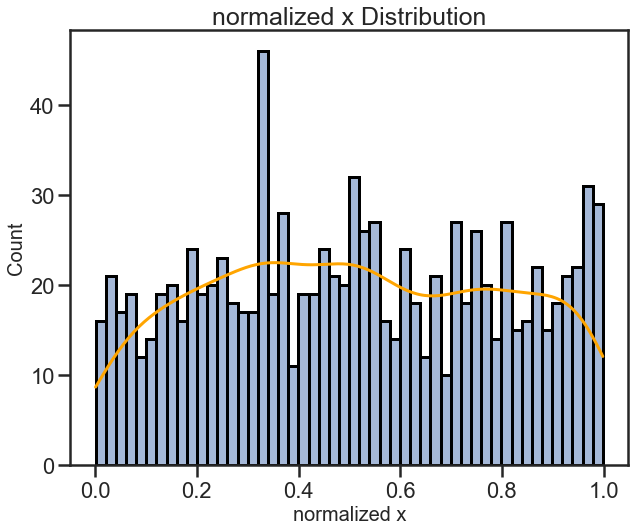

<AxesSubplot:title={'center':'normalized x Distribution'}, xlabel='normalized x', ylabel='Count'>

In [ ]:
histplot(df["x_max_error"] / df["prime"], bins = 50,xlabel = "normalized x")

### When translations

In [ ]:
df3_full = df_full[df_full["mod"] == 3]
df1_full = df_full[df_full['mod'] == 1]

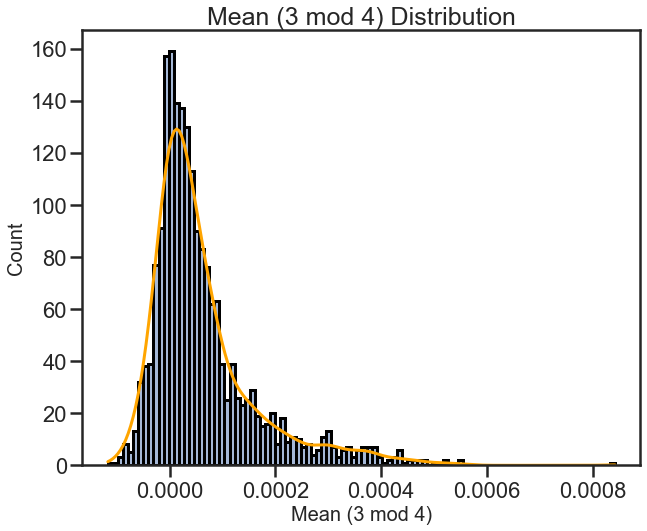

<AxesSubplot:title={'center':'Mean (3 mod 4) Distribution'}, xlabel='Mean (3 mod 4)', ylabel='Count'>

In [ ]:
histplot(df3_full["normalized mean"], bins=100, xlabel="Mean (3 mod 4)")